* X - Permit price and average price as function of baseline
* X - Weighted RRN price and average price as a function of baseline
* X - Weighted RRN price, average price, and price target - table
* X - Permit price and permit price target difference between them - table
* X - Change in relative costs for different types of generators - figure
* Regional price - map of australia - overlaid with blue or red dots - indicates magnitude of price change - subfigures - for different price targets
* X - Change in output from different types of generators - gas increase - coal decrease - for different baselines - emissions overlaid

To fix:
* Change 'baseline' to 'FIXED_BASELINE' in results dict
* Change 'wholesale_price_target' to 'weighted_rrn_price_target'
* Add BAU multiple to weighted_rrn_price_target in results dataframe
* Add permit price being targeted to results dict for permit price targeting model

# Process Results

In [1]:
import os
import re
import math
import pickle

import numpy as np
import pandas as pd
import geopandas as gp

import matplotlib.pyplot as plt

## Paths

In [2]:
# Data directory
data_dir = os.path.join(os.path.curdir, os.path.pardir, os.path.pardir, 'data')

# Scenario directory
scenarios_dir = os.path.join(os.path.curdir, os.path.pardir, '1_create_scenarios', 'output')

# Results directory
results_dir = os.path.join(os.path.curdir, os.path.pardir, '2_parameter_selector', 'output')

# Output directory
output_dir = os.path.join(os.path.curdir, 'output')

## Load data

In [3]:
# Operating scenario data
with open(os.path.join(scenarios_dir, '2_scenarios.pickle'), 'rb') as g:
    scenarios = pickle.load(g)

# Network nodes
df_n = pd.read_csv(os.path.join(data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_nodes.csv'), index_col='NODE_ID')

# Generator data
df_g = pd.read_csv(os.path.join(data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'generators', 'generators.csv'), index_col='DUID')

Load and collate model result data in a single DataFrame.

In [4]:
class results_processor(object):
    "Process results from PYOMO model"
    
    def __init__(self, results_dir):
        # Path to directory containing model results
        self.results_dir = results_dir

    def scenario_results(self, scenario_name):
        """Collate DataFrame results from individual scenarios

        Param
        -----
        paths : list
            List of strings specifying paths to pickled files containing results

        Returns
        -------
        df_o : Pandas DataFrame
            Collated results for different emissions intensity baseline 
            scenarios in a single DataFrame.    
        """

        # Result files
        file_paths = [f for f in os.listdir(self.results_dir) if scenario_name in f]

        # Container for fixed emissions intensity baseline scenario results
        collated_results = list()

        for file in file_paths:
            with open(os.path.join(self.results_dir, file), 'rb') as f:
                result = pickle.load(f)

                # Check that DataFrame exists within result object
                if type(result['results']) != pd.core.frame.DataFrame:
                    raise Exception('Expected DataFrame, received: {}'.format(type(result['results'])))

                # Load DataFrame
                df = result['results']

                # Append values depending on the scenario being investigated
                # Discrete emissions intensity baseline value
                if 'PHI_DISCRETE' in result.keys():
                    df.loc['PHI_DISCRETE', 'Variable'] = [{'Value': result['PHI_DISCRETE']}]

                # Price targeting scenarios
                if 'WEIGHTED_RRN_PRICE_TARGET' in result.keys():
                    df['WEIGTHED_RRN_PRICE_TARGET'] = result['WEIGHTED_RRN_PRICE_TARGET']

                # Fixed baseline scenarios
                if 'baseline' in result.keys():
                    df['FIXED_BASELINE'] = result['baseline']

                # Collate results
                collated_results.append(df)

        # Collated results        
        df_o = pd.concat(collated_results)            

        return df_o
    
    
    def formatted_results(self, scenario_name):
        "Format scenario results by extracting variable and index names"
    
        # Compiled scenario results
        df = self.scenario_results(scenario_name)
    
        # Function used in apply statement to extract variable indices from DataFrame index
        def _extract_index(row):
            "Extract variable indices"

            # Scenario inidices
            # -----------------
            # Extract from index
            scenario_indices = re.findall(r'SCENARIO\[(\d)+\]', row.name)

            # Expect either 1 or 0 values for scenario index
            if len(scenario_indices) == 1:
                scenario_index = int(scenario_indices[0])

            # Raise exception if more than one scenario index encountered
            elif len(scenario_indices) > 1:
                raise(Exception('Only expected 1 scenario index to have one element: {0}'.format(scenario_indices)))
                scenario_index = np.nan

            # If no scenario index, set to null value
            else:
                scenario_index = np.nan


            # Variable indices   
            # ----------------
            # Extract all variable indices from index. Expect at most 2 indices.
            variable_indices = re.findall(r'(?<!SCENARIO)\[([\w\d\,\-\#]+)\]', row.name)

            # Empty list = no variable indices - set to null values
            if len(variable_indices) == 0:
                variable_index_1 = np.nan
                variable_index_2 = np.nan

            elif len(variable_indices) == 1:
                # Split variable indices if separated comma
                variable_indices_split = variable_indices[0].split(',')

                # If no variable indices found, set both to null values
                if len(variable_indices_split) == 0:
                    variable_index_1 = np.nan
                    variable_index_2 = np.nan

                # If only 1 variable index found
                elif len(variable_indices_split) == 1:
                    variable_index_1 = variable_indices_split[0]
                    variable_index_2 = np.nan

                # If 2 variable indices found
                elif len(variable_indices_split) == 2:
                    variable_index_1, variable_index_2 = variable_indices_split

                # Else unexpected number of variable indices encountered (more than 2). Raise exception.
                else:
                    raise(Exception('Unexpected number of variable indices encountered for {0}'.format(variable_indices_split)))

            else:
                raise(Exception('Unexpected number of index components: {0}'.format(variable_indices)))

            # Handle variable name
            if '.' not in row.name:
                if '[' in row.name:
                    variable_name = re.findall(r'(.+)\[', row.name)[0]
                else:
                    variable_name = row.name
            else:
                regex = r'\.(.+)\['
                variable_names = re.findall(regex, row.name)

                if variable_names:           
                    variable_name = variable_names[0]
                else:
                    variable_name = np.nan

            return pd.Series(data={'variable_name': variable_name, 'scenario_index': scenario_index, 'variable_index_1': variable_index_1, 'variable_index_2': variable_index_2})

        # DataFrame with extracted indices
        df[['variable_name', 'scenario_index', 'variable_index_1', 'variable_index_2']] = df.apply(_extract_index, axis=1)
        
        return df

# Instantiate results processor object
results_processor = results_processor(results_dir=results_dir)

In [5]:
df_fixed_baseline = results_processor.formatted_results(scenario_name='fixed_baseline')

# Save results
with open(os.path.join(output_dir, 'temp', 'df_fixed_baseline.pickle'), 'wb') as f:
    pickle.dump(df_fixed_baseline, f)

In [6]:
with open(os.path.join(output_dir, 'temp', 'df_fixed_baseline.pickle'), 'rb') as f:
    df_fixed_baseline = pickle.load(f)

In [7]:
def permit_price_vs_baseline(df, category):
    """Permit price as a function of emissions intensity baseline
    
    Parameters
    ----------
    df : pandas DataFrame
        Input dataframe containing collated scenario results
    
    category : str
        Name of colum which is used to differentiate between scenarios
        e.g. FIXED_BASELINE
        
    Returns
    -------
    df_o : pandas Series
        Permit price corresponding to different scenarios    
    """
    
    # Permit price as a function of emissions intensity baseline
    # Note: Scaling by factor of 100 to take into account prior normalisation
    df_o = (df.loc[df['variable_name']=='tau']
            .apply(lambda x: pd.Series({'tau': x['Variable']['Value'] * 100, 'category': x[category]}), axis=1)
            .set_index('category')['tau'])
    
    return df_o

# Permit price as a function of emissisons intensity baseline
df_tau = permit_price_vs_baseline(df_fixed_baseline, category='FIXED_BASELINE')

In [10]:
def get_average_prices(df, category):
    """Compute average electricity price for NEM regions and also for the nation
    
    Parameters
    ----------
    df : pandas DataFrame
        Input dataframe containing collated scenario results
    
    category : str
        Name of colum which is used to differentiate between scenarios
        e.g. FIXED_BASELINE
        
    Returns
    -------
    df_o : pandas Series
        Average prices for different scenarios for each NEM region and also at the national level
    """

    def _node_revenue_and_demand(row):
        "Compute node revenue and demand for each node for each scenario"

        # Node ID
        node = int(row['variable_index_1'])

        # Scenario ID
        scenario = int(row['scenario_index'])

        # Duration of given scenario [hours]
        duration = scenarios.loc[('hours', 'duration'), scenario]

        # Energy demand at node for given scenario [MWh]
        demand_mwh = scenarios.loc[('demand', node), scenario] * duration

        # Nodal price taking into account data processing normalisation
        price = row['Variable']['Value'] * 100

        # Nodal revenue [$]
        node_revenue = price * demand_mwh

        return pd.Series({'node_revenue': node_revenue, 'demand_mwh': demand_mwh, 'node': node, category: row[category]})

    # Filter so only price records remain and then compute revenue and demand for each node and scenario
    df_rp = df.loc[df['variable_name']=='lamb'].apply(_node_revenue_and_demand, axis=1)
    
    # Merge node information
    df_rp = pd.merge(df_rp, df_n[['RRN', 'NEM_REGION']], how='left', left_on='node', right_index=True)
    
    # Average prices by NEM region for different baselines
    df_regional_prices = df_rp.groupby(['NEM_REGION', category])[['demand_mwh', 'node_revenue']].sum().apply(lambda x: x['node_revenue'] / x['demand_mwh'], axis=1)

    # National average prices
    df_national_prices = df_rp.groupby([category])[['demand_mwh', 'node_revenue']].sum().apply(lambda x: x['node_revenue'] / x['demand_mwh'], axis=1)

    # Add level to index
    df_national_prices.index = pd.MultiIndex.from_tuples([('NATIONAL', b) for b in df_national_prices.index])

    # Average wholesale prices
    df_o = pd.concat([df_regional_prices, df_national_prices])
    
    return df_o

# Average electricity prices for different emissions intensity baselines
df_average_prices = get_average_prices(df_fixed_baseline, category='FIXED_BASELINE')

In [11]:
def get_weighted_rrn_prices(df, category):
    """Compute weighted RRN prices for each baseline scenario
    
    Parameters
    ----------
    df : pandas DataFrame
        Input dataframe containing collated scenario results
    
    category : str
        Name of colum which is used to differentiate between scenarios
        e.g. FIXED_BASELINE
        
    Returns
    -------
    df_o : pandas Series
        Weighted RRN prices for each scenario
    """ 

    # Demand in each NEM region
    region_demand = (scenarios.loc[('demand', slice(None)), :]
                     .reset_index()
                     .set_index('NODE_ID')
                     .join(df_n[['NEM_REGION']], how='left')
                     .groupby('NEM_REGION').sum())

    # Normalised demand - used to weight RRN prices
    rrn_demand_weights = region_demand.div(region_demand.sum())

    # Normalised duration - used to weight RRN prices
    rrn_duration_weights = (scenarios.loc[('hours', 'duration')]
                            .div(scenarios.loc[('hours', 'duration')]
                                 .sum()).to_frame().T)

    # Prices at all nodes
    df_o = df[df['variable_name']=='lamb'].copy()

    # Convert node ID to type int
    df_o.loc[:, 'variable_index_1'] = df_o['variable_index_1'].astype(int)

    # Add region and RRN information
    df_o = pd.merge(df_o, df_n[['NEM_REGION', 'RRN']], how='left', left_on='variable_index_1', right_index=True)

    # Filter so only Regional Reference Nodes (RRNs) remain
    df_o = df_o[df_o['RRN']==1]

    # Weighted RRN prices
    def _weight_rrn_prices(row):
        "Weight RRN prices so they can act as a proxy for average wholesale prices"

        # Normalised duration
        normalised_duration = rrn_duration_weights.loc[('hours', 'duration'), row['scenario_index']]

        # RRN price - scaled by factor of 100 to take into account prior normalisation
        rrn_price = float(row['Variable']['Value']) * 100

        # Normalised demand
        normalised_region_demand = rrn_demand_weights.loc[row['NEM_REGION'], row['scenario_index']]

        return rrn_price * normalised_duration * normalised_region_demand

    df_o['weighted_prices'] = df_o.apply(_weight_rrn_prices, axis=1)

    df_o = df_o.groupby(category)['weighted_prices'].sum()
    
    return df_o
df_weighted_rrn_prices = get_weighted_rrn_prices(df_fixed_baseline, category='FIXED_BASELINE')

Permit price and average national price as a function of baseline

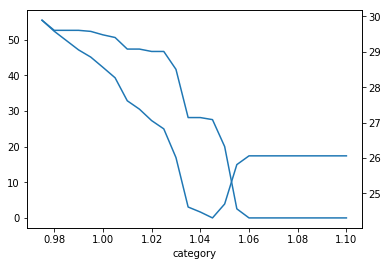

In [12]:
plt.clf()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
df_tau.plot(ax=ax1)
ax = df_average_prices.loc['NATIONAL'].plot(ax=ax2)
plt.show()

Weighted RRN price and average price as a function of baseline

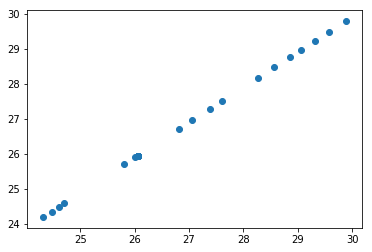

In [13]:
plt.clf()
plt.scatter(df_average_prices['NATIONAL'].tolist(), df_weighted_rrn_prices.tolist())
plt.show()

In [14]:
df = df_fixed_baseline.copy()
df.loc[df['variable_name']=='p'].apply(lambda x: pd.Series({'Value': float(x['Variable']['Value']),
                                                            'scenario_index': x['scenario_index']}), axis=1)

,Value,scenario_index
SCENARIO[1].p[AGLHAL],-0.00,1.0
SCENARIO[1].p[AGLSOM],-0.00,1.0
SCENARIO[1].p[ANGAST1],-0.00,1.0
SCENARIO[1].p[BARCALDN],-0.00,1.0
SCENARIO[1].p[BBTHREE1],-0.00,1.0
SCENARIO[1].p[BBTHREE2],-0.00,1.0
SCENARIO[1].p[BBTHREE3],-0.00,1.0
SCENARIO[1].p[BDL01],-0.00,1.0
SCENARIO[1].p[BDL02],-0.00,1.0
SCENARIO[1].p[BRAEMAR1],-0.00,1.0


In [15]:
def _get_generator_output(row):
    # DUID
    duid = row['variable_index_1']
    
    # Duration of given scenario [hours]
    duration = scenarios.loc[('hours', 'duration'), row['scenario_index']]
    
    # Average power output during scenario
    power_output = float(row['Variable']['Value'])
    
    # Energy output - scale by factor of 100 to take into account prior normalisation [MWh]
    energy_output = power_output * duration * 100
    
    # Emissions [tCO2]
    emissions = energy_output * df_g.loc[duid, 'EMISSIONS']
    
    return pd.Series({'energy_output': energy_output,
                      'DUID': duid,
                      'scenario_index': row['scenario_index'],
                      'FIXED_BASELINE': row['FIXED_BASELINE'],
                      'emissions': emissions})

df_generator_output = df.loc[df['variable_name']=='p'].apply(_get_generator_output, axis=1)   

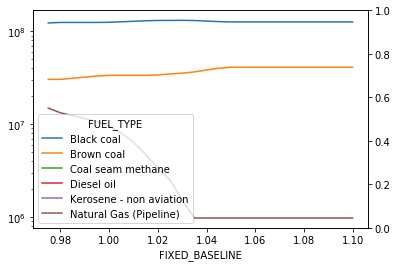

In [16]:
# Energy output from different types of generators
df_energy = pd.merge(df_generator_output, df_g[['NEM_REGION', 'FUEL_TYPE', 'FUEL_CAT']], how='left', left_on='DUID', right_index=True).groupby(['FUEL_TYPE', 'FIXED_BASELINE'])[['energy_output']].sum().reset_index().pivot(index='FIXED_BASELINE', columns='FUEL_TYPE', values='energy_output')

# Emissions from different types of generators
df_emissions = pd.merge(df_generator_output, df_g[['NEM_REGION', 'FUEL_TYPE', 'FUEL_CAT']], how='left', left_on='DUID', right_index=True).groupby(['FUEL_TYPE', 'FIXED_BASELINE'])[['emissions']].sum().reset_index().pivot(index='FIXED_BASELINE', columns='FUEL_TYPE', values='emissions')


plt.clf()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
pd.merge(df_generator_output, df_g[['NEM_REGION', 'FUEL_TYPE', 'FUEL_CAT']], how='left', left_on='DUID', right_index=True).groupby(['FUEL_TYPE', 'FIXED_BASELINE'])['energy_output'].sum().reset_index().pivot(index='FIXED_BASELINE', columns='FUEL_TYPE', values='energy_output').plot(logy=True, ax=ax1)
plt.show()

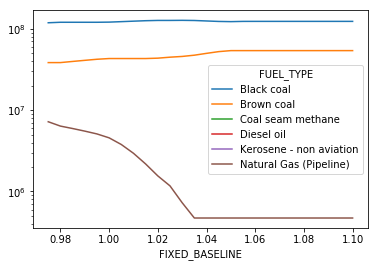

In [17]:
plt.clf()
df_emissions.plot(logy=True)
plt.show()

In [18]:
def construct_srmc_comparison(df_tau, df_g, fuel_types):
    """Compare SRMCs for different generators for different baselines
    
    Parameters
    ----------
    df_tau : pandas Series
        Permit prices for different emissions intensity baselines
    
    df_g : pandas DataFrame
        Generator parameters. e.g. SRMCs and emissions intensities
        
    fuel_types : list
        List of fuel types for which the comparison should be carried out
    
    Returns
    -------
    means : pandas DataFrame
        Contains mean SRMCs for different fuel types and emissions intensity baselines
    
    errors : pandas DataFrame
        SRMC standard deviations for different fuel types and emissions intensity baselines
    """
    
    # Container for SRMC DataFrames
    dfs = []

    # Loop through each fixed baseline scenario
    for index, row in df_tau.iteritems():
        # Compute udpated SRMCs
        s_srmc = df_g['SRMC_2016-17'] + (df_g['EMISSIONS'] - index) * row

        # Format columns and add fixed baseline and tau to indentify scenario
        df_srmc = s_srmc.to_frame().rename(columns={0: 'SRMC'})
        df_srmc['FIXED_BASELINE'] = index
        df_srmc['tau'] = row

        # Append to DataFrame container
        dfs.append(df_srmc)

    # Concatenate DataFrames. Compute mean and standard deviation for SRMCs for generators of different fuel types
    df = (pd.concat(dfs)
          .drop('tau', axis=1)
          .join(df_g['FUEL_TYPE'], how='left')
          .groupby(['FIXED_BASELINE', 'FUEL_TYPE'])
          .apply(lambda x: pd.Series({'SRMC': x['SRMC'].mean(), 'std': x['SRMC'].std()})))

    # Standard deviation for selected generators
    errors = df[df.index.get_level_values(1).isin(fuel_types)].reset_index().pivot(index='FIXED_BASELINE', columns='FUEL_TYPE', values='std')

    # Mean SRMC for selected generators
    means = df[df.index.get_level_values(1).isin(fuel_types)].reset_index().pivot(index='FIXED_BASELINE', columns='FUEL_TYPE', values='SRMC')
    
    return means, errors

means, errors = construct_srmc_comparison(df_tau, df_g, ['Black coal', 'Brown coal', 'Natural Gas (Pipeline)'])

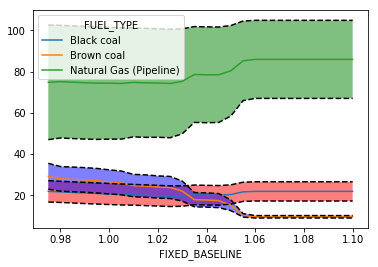

In [19]:
plt.clf()
fig, ax1 = plt.subplots()

means.plot(ax=ax1)
means.add(errors).plot(ax=ax1, style='--', color='k', legend=False)
means.subtract(errors).plot(ax=ax1, style='--', color='k', legend=False)

# Fill line between upper and lower standard deviation and mean SRMC
ax1.fill_between(means.index, means.subtract(errors)['Natural Gas (Pipeline)'], means.add(errors)['Natural Gas (Pipeline)'], facecolor='green', alpha=0.5)
ax1.fill_between(means.index, means.subtract(errors)['Black coal'], means.add(errors)['Black coal'], facecolor='red', alpha=0.5)
ax1.fill_between(means.index, means.subtract(errors)['Brown coal'], means.add(errors)['Brown coal'], facecolor='blue', alpha=0.5)

plt.show()

Results from model used to target weighted Regional Reference Node prices

In [20]:
# Results from model used to target weighted Regional Reference Node prices
df_weighted_rrn_price_target = results_processor.formatted_results(scenario_name='wholesale_electricity_price_target')

# Average electricity prices for different emissions intensity baselines
df_wrpt_average_prices = get_average_prices(df_weighted_rrn_price_target, category='WEIGTHED_RRN_PRICE_TARGET')

# Sort index to allow slicing
df_wrpt_average_prices = df_wrpt_average_prices.sort_index()

# Weighted RRN prices
df_wrpt_weighted_rrn_prices = get_weighted_rrn_prices(df_weighted_rrn_price_target, category='WEIGTHED_RRN_PRICE_TARGET')

# Comparision between price target, weighted prices, and average prices
df_wrpt_average_prices.loc[(slice('NATIONAL'), slice(None))].reset_index().drop('NEM_REGION', axis=1).set_index('WEIGTHED_RRN_PRICE_TARGET').rename(columns={0: 'average_prices'}).join(df_wrpt_weighted_rrn_prices.to_frame(), how='left')

ValueError: No objects to concatenate

Results from model used to target permit prices

In [ ]:
# Results from model used to target weighted Regional Reference Node prices
df_permit_price_target = results_processor.formatted_results(scenario_name='permit_price_target')

# Permit price
df_permit_price_target.loc[df_permit_price_target['variable_name']=='tau'].apply(lambda x: x['Variable']['Value'], axis=1)

Regional price impacts for different baselines.

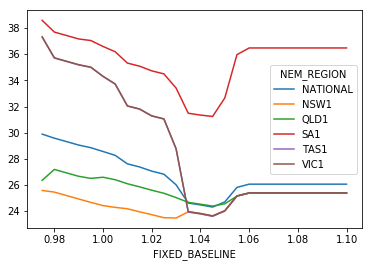

In [21]:
plt.clf()
# Average prices in each NEM region, including aggregate national values
df_average_prices.reset_index().pivot(index='FIXED_BASELINE', columns='NEM_REGION', values=0).plot()
plt.show()